# Question 4 and 5 Windy Gridworld Domain

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

In [85]:
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # # define the action space
        # self.action_space = {
        #     "up": np.array([-1, 0]),
        #     "down": np.array([1, 0]),
        #     "left": np.array([0, -1]),
        #     "right": np.array([0, 1])
        # }
        
        # Enable King's moves (Comment out the above action space to create a new one for King's moves)
        if enable_king_move:
            
            if enable_no_move:
                action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up right": np.array([-1, 1]),
                    "up left": np.array([-1, -1]),
                    "down right": np.array([1, 1]),
                    "down left": np.array([1, -1]),
                    "none": np.array([0, 0])
                }
            else:
                action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up right": np.array([-1, 1]),
                    "up left": np.array([-1, -1]),
                    "down right": np.array([1, 1]),
                    "down left": np.array([1, -1])
                }
        
        else:
            action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }
            
        self.action_space = action_space
            
                
        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        if act not in self.action_space.keys():
            raise ValueError(f"Invalid action: {act}")

        if self.state == self.goal_state:
            return self.state, 0, True

        next_state_row = self.state[0] - self.wind[self.state[1]] + self.action_space[act][0]
        next_state_col = self.state[1] + self.action_space[act][1]

        next_state_row = max(0, next_state_row)
        next_state_row = min(self.grid.shape[0]-1, next_state_row)

        next_state_col = max(0, next_state_col)
        next_state_col = min(self.grid.shape[1]-1, next_state_col)

        self.state = [next_state_row, next_state_col]

        if self.state == self.goal_state:
            reward = 0
            terminated = True
        else:
            reward = -1
            terminated = False
        
        return self.state, reward, terminated

    def set_state(self, state):
        self.state = state

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)


In [86]:
def argmax(l: List[float]) -> int:
    """Argmax to break ties randomly"""
    l = np.array(l)
    return np.random.choice(np.flatnonzero(l == l.max()))

class SARSA(object):
    def __init__(self, env, alpha: float, epsilon: float, gamma: float, timeout: int):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state: str) -> str:
        """Chooses action using epsilon greedy policy from Q"""
        r = np.random.rand()

        if r < self.epsilon:
            return np.random.choice(list(self.env.action_space.keys()))
        else:
            action_idx = argmax(list(self.Q[self.env.state_space.index(state), :]))
            return list(self.env.action_space.keys())[action_idx]

    def update(self, s: str, a: str, r: float, s_prime: str, a_prime: str) -> None:
        """Update Q function"""
        self.Q[self.sa_to_idx(s, a)] += self.alpha * (r + self.gamma * self.Q[self.sa_to_idx(s_prime, a_prime)] - self.Q[self.sa_to_idx(s, a)])

    def rollout(self):
        """Run an episode of SARSA"""
        state, done = self.env.reset()
        episode_len = 0
        
        action = self.behavior_policy(state)
        
        while not done and episode_len < self.timeout:
            next_state, reward, done = self.env.step(action)
            next_action = self.behavior_policy(next_state)

            self.update(state, action, reward, next_state, next_action)

            state = next_state
            action = next_action
            episode_len += 1
            
        return done, episode_len

    def run(self) -> None:
        episode_num = 0
        episodes = []
        
        while len(episodes) < self.timeout:
            finished_episode, episode_len = self.rollout()
            episodes.extend([episode_num] * episode_len)

            if finished_episode:
                episode_num += 1

        return episodes[:self.timeout]

    def sa_to_idx(self, s: str, a: str) -> Tuple[int, int]:
        """Convert string state and action to tuple index"""
        return self.env.state_space.index(s), list(self.env.action_space.keys()).index(a)

In [87]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        """Chooses action using epsilon greedy policy from Q"""
        r = np.random.rand()

        if r < self.epsilon:
            return np.random.choice(list(self.env.action_space.keys()))
        else:
            action_idx = argmax(self.Q[self.s_to_idx(state), :])
            return list(self.env.action_space.keys())[action_idx]

    def update(self, s, a, r, s_prime):
        """Update Q function"""
        sum_term = 0
        for action in self.env.action_space.keys():
            # get pi(a|s')
            if self.a_to_idx(action) == np.argmax(self.Q[self.s_to_idx(s_prime), :]):
                prob_action = (1 - self.epsilon) + (self.epsilon / self.action_num)
            else:
                prob_action = (self.epsilon / self.action_num)
                
            sum_term += prob_action * self.Q[self.sa_to_idx(s_prime, action)]
            
        self.Q[self.sa_to_idx(s, a)] += self.alpha * (r + self.gamma * sum_term - self.Q[self.sa_to_idx(s, a)])

    def rollout(self):
        """Run an episode of q learning"""
        state, done = self.env.reset()
        episode_len = 0
        
        while not done and episode_len < self.timeout:
            action = self.behavior_policy(state)
            next_state, reward, done = self.env.step(action)

            self.update(state, action, reward, next_state)

            state = next_state
            episode_len += 1
            
        return done, episode_len

    def run(self):
        episode_num = 0
        episodes = []
        
        while len(episodes) < self.timeout:
            finished_episode, episode_len = self.rollout()
            episodes.extend([episode_num] * episode_len)

            if finished_episode:
                episode_num += 1

        return episodes[:self.timeout]

    def sa_to_idx(self, s: str, a: str) -> Tuple[int, int]:
        """Convert string state and action to tuple index"""
        return self.s_to_idx(s), self.a_to_idx(a)

    def s_to_idx(self, s):
        return self.env.state_space.index(s)

    def a_to_idx(self, a):
        return list(self.env.action_space.keys()).index(a)

In [88]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        """Chooses action using epsilon greedy policy from Q"""
        r = np.random.rand()

        if r < self.epsilon:
            return np.random.choice(list(self.env.action_space.keys()))
        else:
            action_idx = argmax(list(self.Q[self.env.state_space.index(state), :]))
            return list(self.env.action_space.keys())[action_idx]

    def update(self, s, a, r, s_prime):
        """Update Q function"""
        self.Q[self.sa_to_idx(s, a)] += self.alpha * (r + self.gamma * np.max(self.Q[self.env.state_space.index(s_prime), :]) - self.Q[self.sa_to_idx(s, a)])

    def rollout(self):
        """Run an episode of q learning"""
        state, done = self.env.reset()
        episode_len = 0
        
        while not done and episode_len < self.timeout:
            action = self.behavior_policy(state)
            next_state, reward, done = self.env.step(action)

            self.update(state, action, reward, next_state)

            state = next_state
            episode_len += 1
            
        return done, episode_len

    def run(self):
        episode_num = 0
        episodes = []
        
        while len(episodes) < self.timeout:
            finished_episode, episode_len = self.rollout()
            episodes.extend([episode_num] * episode_len)

            if finished_episode:
                episode_num += 1

        return episodes[:self.timeout]

    def sa_to_idx(self, s: str, a: str) -> Tuple[int, int]:
        """Convert string state and action to tuple index"""
        return self.env.state_space.index(s), list(self.env.action_space.keys()).index(a)

In [91]:
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

    Make sure the elements in the arr_list, legend_list, and color_list are associated with each other correctly.
    Do not forget to change the ylabel for different plots.
    """
    # Clear the current figure
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the mean and standard error while ignoring NaN values
        mean_arr = np.nanmean(arr, axis=0)
        arr_err = np.nanstd(arr, axis=0) / np.sqrt(np.sum(~np.isnan(arr), axis=0))
        
        # Plot the mean
        h, = ax.plot(range(len(mean_arr)), mean_arr, color=color, label=legend)
        
        # Plot the confidence band
        arr_err = 1.96 * arr_err  # 95% confidence interval
        ax.fill_between(range(len(mean_arr)),
                        mean_arr - arr_err,
                        mean_arr + arr_err,
                        alpha=0.3, color=color)
        # Save the plot handle
        h_list.append(h)

    # Set the title (adjust as needed)
    ax.set_title("Windy Gridworld Results")
    ax.legend(handles=h_list)
    plt.show()

In [228]:
def run_on_policy_td_control(run_num, timeout):
    
    enable_king_move_actions = False
    enable_no_move_actions = False
    
    # create the environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions, enable_no_move=enable_no_move_actions)

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0

    # create the expected SARSA
    expected_sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        # append the results
        expected_sarsa_results_list.append(episodes[0:8000])
        
    # create the SARSA
    sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        # append the results
        sarsa_results_list.append(episodes[0:8000])

    # create the Q learning
    q_learning_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        # append the results
        q_learning_results_list.append(episodes[0:8000])
    
    sarsa_array = np.array(sarsa_results_list)
    expected_sarsa_array = np.array(expected_sarsa_results_list)
    q_learning_array = np.array(q_learning_results_list)
    
    # Plot the results
    plot_curves(
        [sarsa_array, expected_sarsa_array, q_learning_array],
        ['SARSA', 'Expected SARSA', 'Q-learning'],
        ['r', 'b', 'g'],
        "Episodes"
    )

# (a) 

<Figure size 432x288 with 0 Axes>

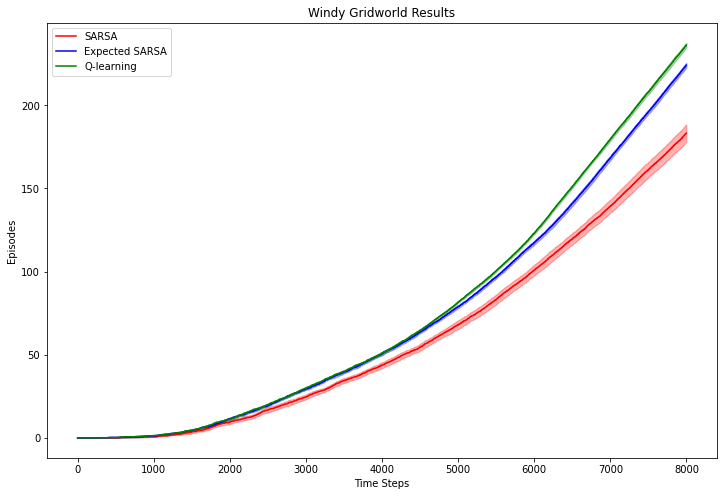

In [287]:
# set randomness
np.random.seed(1234)
random.seed(1234)

# trial number
trial_num = 10
# maximal time steps
max_time_steps = 8000

# run SARSA and Q Learning
run_on_policy_td_control(trial_num, max_time_steps)

# (b)

In [89]:
# environments
env_normal = WindyGridWorld(enable_king_move=False, enable_no_move=False)
env_king_move = WindyGridWorld(enable_king_move=True, enable_no_move=False)
env_king_and_no_move = WindyGridWorld(enable_king_move=True, enable_no_move=True)

# parameters
epsilon = 0.1
alpha = 0.5
gamma = 1.0
run_num = 10
timeout = 8000

# create the expected SARSA
expected_sarsa_dict = {"normal": None, "king move": None, "king no move": None}
for env, key in zip([env_normal, env_king_move, env_king_and_no_move], expected_sarsa_dict.keys()):
    expected_sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        # append the results
        expected_sarsa_results_list.append(episodes[0:8000])

    expected_sarsa_dict[key] = np.array(expected_sarsa_results_list)
    
# create the SARSA
sarsa_dict = {"normal": None, "king move": None, "king no move": None}
for env, key in zip([env_normal, env_king_move, env_king_and_no_move], sarsa_dict.keys()):
    sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        # append the results
        sarsa_results_list.append(episodes[0:8000])

    sarsa_dict[key] = np.array(sarsa_results_list)

# create the Q learning
q_learning_dict = {"normal": None, "king move": None, "king no move": None}
for env, key in zip([env_normal, env_king_move, env_king_and_no_move], q_learning_dict.keys()):
    q_learning_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        # append the results
        q_learning_results_list.append(episodes[0:8000])

    q_learning_dict[key] = np.array(q_learning_results_list)

<Figure size 432x288 with 0 Axes>

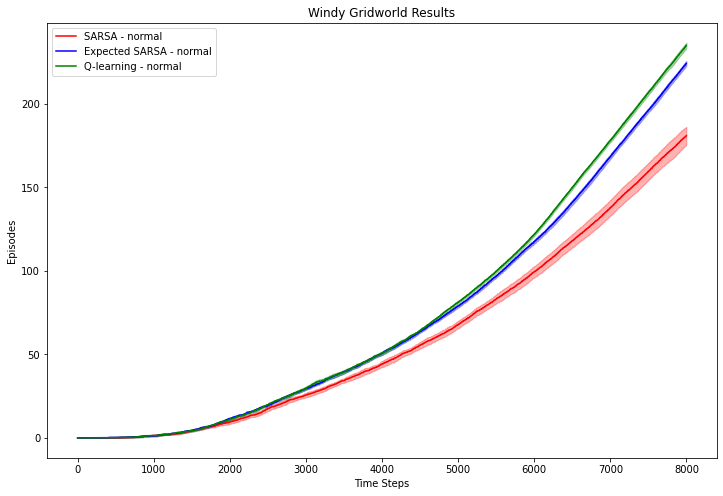

<Figure size 432x288 with 0 Axes>

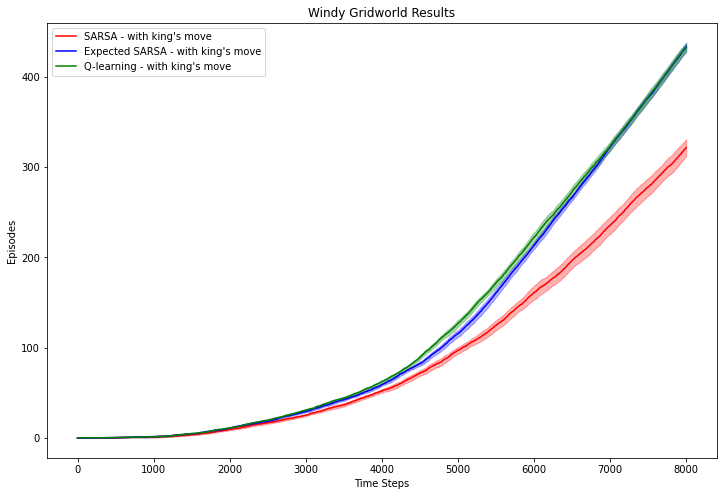

<Figure size 432x288 with 0 Axes>

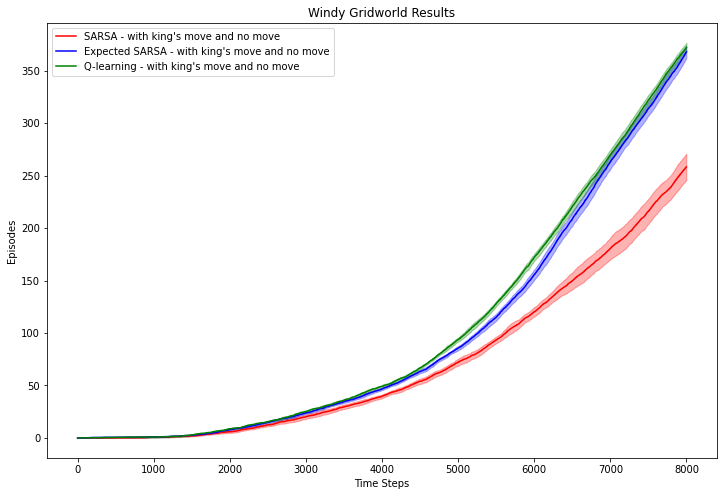

In [92]:
# plot with normal moves
plot_curves(
    [sarsa_dict["normal"], expected_sarsa_dict["normal"], q_learning_dict["normal"]],
    ['SARSA - normal', 'Expected SARSA - normal', 'Q-learning - normal'],
    ['r', 'b', 'g'],
    "Episodes"
)

# plot with king's move
plot_curves(
    [sarsa_dict["king move"], expected_sarsa_dict["king move"], q_learning_dict["king move"]],
    ['SARSA - with king\'s move', 'Expected SARSA - with king\'s move', 'Q-learning - with king\'s move'],
    ['r', 'b', 'g'],
    "Episodes"
)

# plot with king's and no move

plot_curves(
    [sarsa_dict["king no move"], expected_sarsa_dict["king no move"], q_learning_dict["king no move"]],
    ['SARSA - with king\'s move and no move', 'Expected SARSA - with king\'s move and no move', 'Q-learning - with king\'s move and no move'],
    ['r', 'b', 'g'],
    "Episodes"
)


# Question 5 [5180 ONLY]
- Please refer to starter code from question 4 to help you get started. You will create your own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain. 
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to      estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. In
this question, S is the initial state marked as S in the Example 6.5.
- To do so, you need to collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.
- Note that in practice you should pre-collect both the training and evaluation episodes for efficiency and to
ensure consistency while comparing between different methods.

In [54]:
# collect near otpimal policy from SARSA
env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
alpha = 0.5
epsilon = 0.1
gamma = 1
timeout = 80000  # run for more iterations to ensure policy converges

controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
_ = controller_sarsa.run()

policy = list(np.argmax(controller_sarsa.Q, axis=1)) # policy[state_idx] = action is the policy to evaluate

In [103]:
class TDZero(object):
    def __init__(self, env, alpha, gamma, policy, n):
        # define the parameters
        self.alpha = alpha
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.V = np.zeros(self.state_num)

        # number of episodes to learn from
        self.n = n

        # policy to evaluate
        self.policy = policy

    def pi(self, state):
        """Get action using policy being evaluated"""
        return list(self.env.action_space.keys())[self.policy[self.s_to_idx(state)]]
        
    def update(self, s, r, s_prime):
        """Update value function"""
        self.V[self.s_to_idx(s)] += self.alpha * (r + self.gamma * self.V[self.s_to_idx(s_prime)] - self.V[self.s_to_idx(s)])

    def rollout(self):
        """Run an episode"""
        state, done = self.env.reset()
        
        while not done:
            action = self.pi(state)
            next_state, reward, done = self.env.step(action)

            self.update(state, reward, next_state)

            state = next_state
            
    def run(self):
        for _ in range(self.n):
            self.rollout()

    def evaluate(self, num_episodes=100):
        targets = []
        for _ in range(num_episodes):
            state, done = self.env.reset()

            while not done:
                action = self.pi(state)
                next_state, reward, done = self.env.step(action)

                targets.append(reward + self.V[self.s_to_idx(next_state)])
                state = next_state
                    
        return targets
        
    def s_to_idx(self, s):
        return self.env.state_space.index(s)

In [102]:
class MonteCarlo(object):
    def __init__(self, env, gamma, policy, n):
        # define the parameters
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.V = np.zeros(self.state_num)
        self.count = np.zeros(self.state_num)  # number of times each state has been visited

        # number of episodes to learn from
        self.n = n

        # policy to evaluate
        self.policy = policy

    def pi(self, state):
        """Get action using policy being evaluated"""
        return list(self.env.action_space.keys())[self.policy[self.s_to_idx(state)]]
        
    def update(self, state_list, reward_list):
        """Update value function based on episode rollout"""
        g = 0
        for state, reward in zip(state_list[::-1], reward_list[::-1]):
            g += self.gamma * reward
            self.V[self.s_to_idx(state)] += g
            self.count[self.s_to_idx(state)] += 1

    def rollout(self):
        """Run an episode"""
        state, done = self.env.reset()
        state_list = []
        reward_list = []
        
        while not done:
            action = self.pi(state)
            next_state, reward, done = self.env.step(action)

            state_list.append(state)
            reward_list.append(reward)
            state = next_state

        return state_list, reward_list
            
    def run(self):
        for _ in range(self.n):
            state_list, reward_list = self.rollout()
            self.update(state_list, reward_list)

    def evaluate(self, num_episodes=100):
        targets = []
        for _ in range(num_episodes):
            _, reward_list = self.rollout()

            g = 0
            for reward in reward_list[::-1]:
                g += self.gamma * reward
                targets.append(g)
                
        return targets
        
    def s_to_idx(self, s):
        return self.env.state_space.index(s)

In [75]:
def plot_hist(data, title, value):
    fig, ax = plt.subplots()
    ax.hist(data, bins=range(-100, 1))
    ax.axvline(value, color="k", linestyle="--")

    ax.set_xlabel("learning target")
    ax.set_ylabel("count")
    ax.set_title(title)

    fig.legend(["true value", "learning target"], loc="upper left", bbox_to_anchor=(0.9, 0.9))

    plt.show()

In [66]:
def run_policy_evaluation(env, policy):
    env.reset()
    
    # initialize V(s) to 0
    v = np.zeros(len(env.state_space))
    theta = 1e-4
    gamma = 1
    
    while True:
        delta = 0
        for s in env.state_space:
            idx = env.state_space.index(s)
    
            env.set_state(s)
            next_state, reward, _ = env.step(list(env.action_space.keys())[policy[idx]])
            
            prev_v = v[idx]
            v[idx] = reward + gamma*v[env.state_space.index(next_state)]
    
            delta = max(delta, abs(prev_v - v[idx]))
        if delta < theta:
            break
    return v[env.state_space.index(env.start_state)]

In [105]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld(policy):
    enable_king_move_actions = False
    enable_no_move_actions = False
    alpha = 0.5
    gamma = 1
    
    # create environments
    env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                         enable_no_move=enable_no_move_actions)

    # get real value from DP
    true_value = run_policy_evaluation(env, policy)

    # run TD(0)
    for n in [1, 10, 50]:
        env.reset()
        td_zero = TDZero(env, alpha, gamma, policy, n)
        td_zero.run()
        td_zero_data = td_zero.evaluate(1000)

        plot_hist(td_zero_data, f"TD(0): N = {n}", true_value)

    # run MC every visit
    for n in [1, 10, 50]:
        env.reset()
        mc = MonteCarlo(env, gamma, policy, n)
        mc.run()
        mc_data = mc.evaluate(1000)
        plot_hist(mc_data, f"MC: N = {n}", true_value)

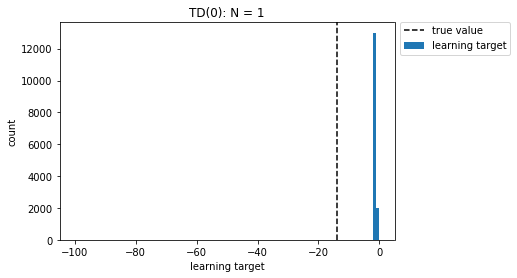

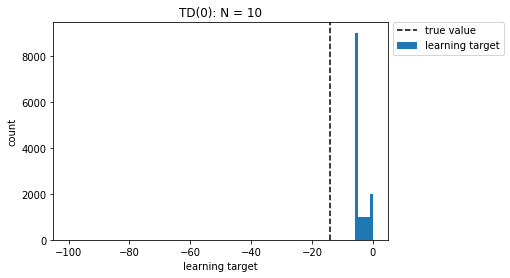

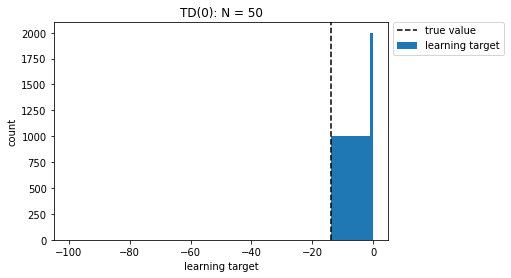

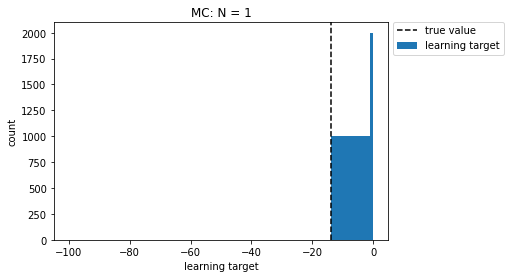

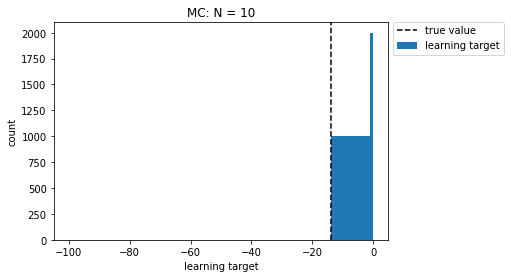

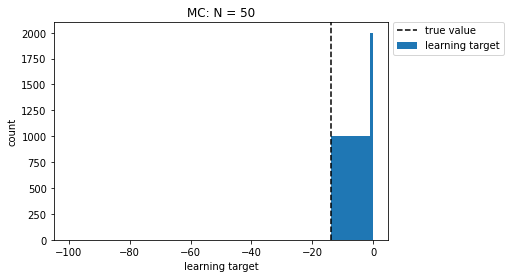

In [106]:
if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # run Monte Carlo and TD(0) for Question 6. Modify as necessary
    run_on_policy_mc_td_epsilon_greedy_windy_gridworld(policy)